<h1> Phase 3 Final Project Submission</h1>

<h3>Student name: Jason Lombino

<h1>Business Problem

Reducing customer churn is an important part of running a successful business. It is more expensive to acquire new customers through advertising and promotions than it is to keep existing customers. In addition, it is often the customers who are paying the most who are the fastest to switch to a competitor for better pricing. Telecomunications company SyriaTel would like to focus on retaining customers by offering discounted rates to customers who are likely to leave soon. In order to do this, SyriaTel needs a model to predict which customers are likely to churn. 

Provided with data on customers' accounts, the model should be helpful in answering the following questions:


<ol>
<li>Will a given customer leave SyriaTel soon?
<li>Which account features best predict whether a customer will soon churn?
</ol>

SyriaTel should be able to use this model to target all customers who will churn with discounted rates while avoiding discounting rates for customers who will not. My primary metric for the model will be <b>Recall Score</b> because it is most important that the model correctly identifies as many churning customers as possible. I will then focus on Precision Score to avoid giving out unnecessary discounts to customers who will not churn.

<h1>SyriaTel Data

The following <a href=https://www.kaggle.com/becksddf/churn-in-telecoms-dataset>dataset</a> was provided by SyriaTel for modeling. It contains information on the account usage and history of 3300 SyriaTel customers in the United States. The target column {churn} shows whether a given customer left SyriaTel during a one-month time frame. The dataset can be found in this repositiory at <a href=./data/s_tel.csv>./data/s_tel.csv</a>.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from xgboost import XGBClassifier as xgb
import shap

from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer,\
    plot_confusion_matrix,fbeta_score, roc_auc_score, classification_report

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier

from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import SMOTENC

plt.style.use('ggplot')

I will begin the modeling process by loading in the data and dropping the phone number and area code columns. These columns result in a unique identifier for the customers that I do not want the model fitting to.

In [2]:
# Load in the data
s_tel = pd.read_csv('data/s_tel.csv')

# Drop phone number and area code so the data does not have a unique identifier
s_tel.drop(['phone number','area code'],axis=1,inplace=True)
s_tel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   international plan      3333 non-null   object 
 3   voice mail plan         3333 non-null   object 
 4   number vmail messages   3333 non-null   int64  
 5   total day minutes       3333 non-null   float64
 6   total day calls         3333 non-null   int64  
 7   total day charge        3333 non-null   float64
 8   total eve minutes       3333 non-null   float64
 9   total eve calls         3333 non-null   int64  
 10  total eve charge        3333 non-null   float64
 11  total night minutes     3333 non-null   float64
 12  total night calls       3333 non-null   int64  
 13  total night charge      3333 non-null   float64
 14  total intl minutes      3333 non-null   

No missing data is good. The only thing I need to address immediately is changing the target column (churn) to an integer so it can be used in the model/

In [3]:
# The target value should be type int so it works in SKLearn
s_tel.churn = s_tel.churn.apply(int)
s_tel.churn.value_counts()

0    2850
1     483
Name: churn, dtype: int64

<h2>Class Imbalence</h2>

Based on the churn value counts, it looks like there is about a 6:1 class imbalence in the dataset. That is there are six times more non-churners than churners. This can be a problem for many models and will need to be addressed using a method such as weighting the data points by class.

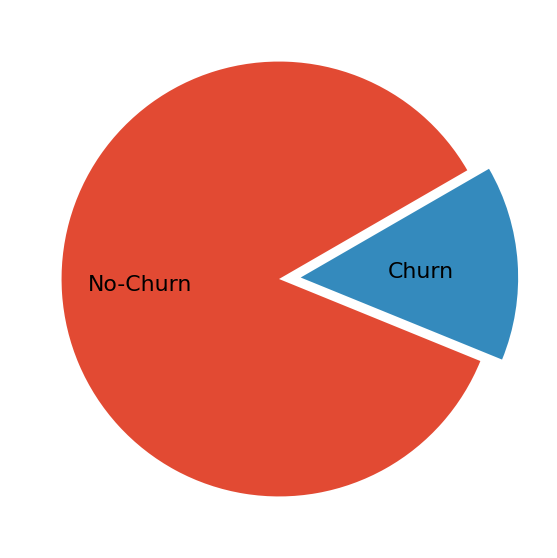

In [4]:
fig,ax = plt.subplots(figsize=(10,10))
sns.set_context('poster')

# Pie chart to visualize class imbalence
ax.pie(s_tel.groupby('churn').size(),labels=['No-Churn','Churn'],labeldistance=0.4,
        startangle=30,explode=[0,0.1]);
sns.set_context('notebook')

<h1>Exploratory Data Analysis

I will begin by plotting the distrobution of each of the predictor columns. Thankfully, pandas has a convenient method for this.

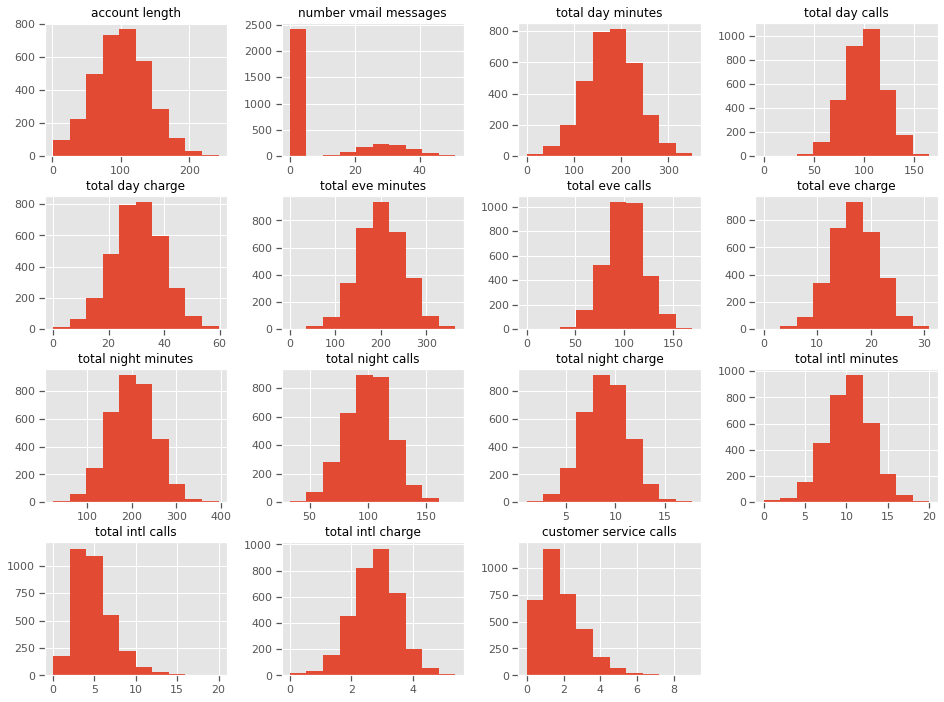

In [5]:
pd.plotting.hist_frame(s_tel.drop('churn',axis=1),figsize=(16,12));

I will also take a look at the correlation coefficients between each of the predictor columns. Here, it looks like some of the columns are perfectly correlated. It makes sense that total charge would be an integer multiple of minutes, so to avoid issues with multicolinearity I will later drop all of the minutes columns and keep the charge columns.

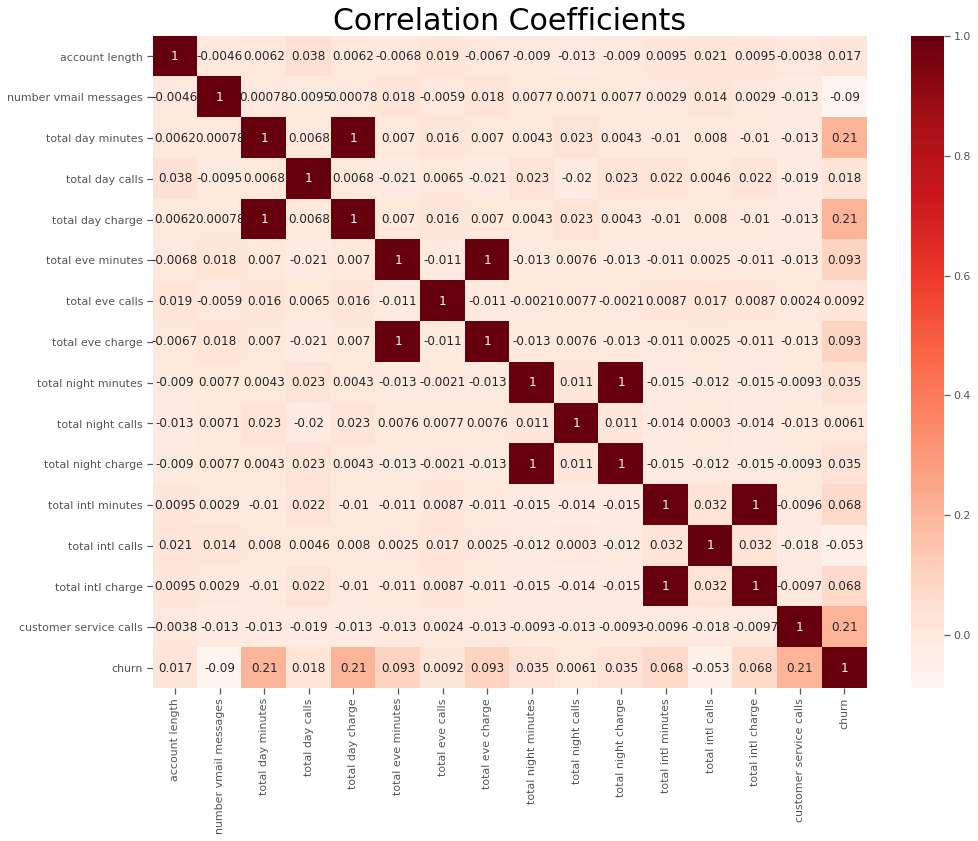

In [6]:
fig,ax = plt.subplots(figsize = (16,12))

# Heatmap to visaulize correlation between features
ax.set_title('Correlation Coefficients',fontsize=30);
sns.heatmap(s_tel.corr(),annot=True,ax=ax,cmap='Reds');

<h2>Features</h2>

Now, I will take a look at all of the remaining features separately. I will divide each of the features into churned and not-churned groups and compare the groups using a statistical test. The goal is to determine whether a customer will churn, so I will be looking for a significant difference between the groups for each feature. While I won't be dropping and data yet, this should help me get an idea of which features will be the most useful predictors of churn.

<h3>States</h3>

There definitely seems to be a difference between the churn rates for each state, but the difference is not huge. One-hot encoding state will add a large amount of complexity to my model for presumably little predicitve power so this will be one of the first columns I look to drop.

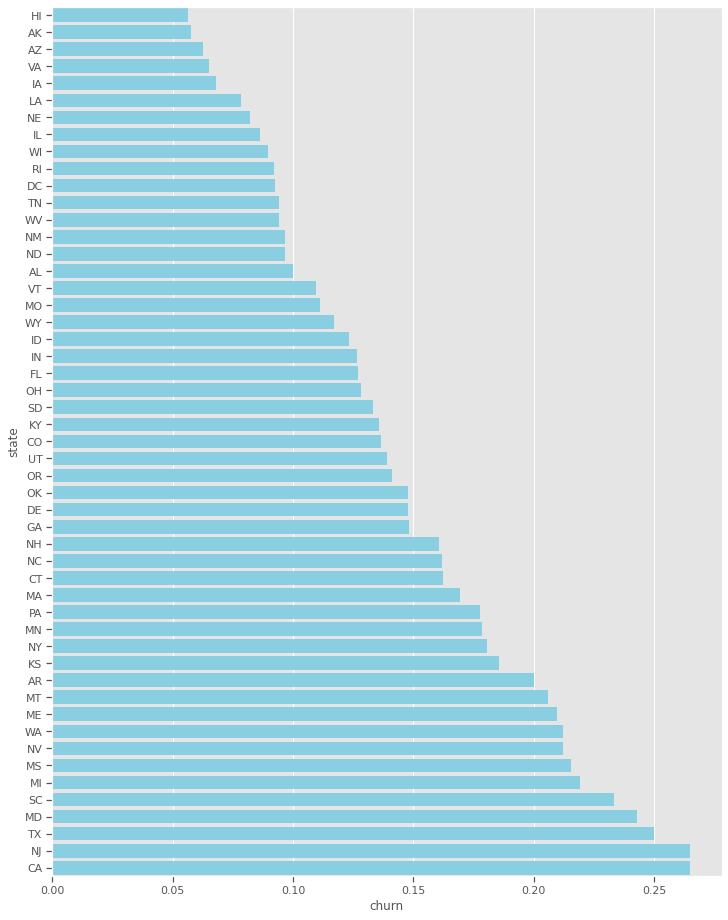

In [7]:
# The mean of churn is the percentage of people who churned
states = s_tel.groupby('state').churn.agg(np.mean)
states.sort_values(ascending=True, inplace=True)
fig,ax = plt.subplots(figsize=(12,16))
sns.barplot(x=states,y=states.index,ax=ax,color='#7ad7f0');

In [8]:
# Make future plots easier to see
sns.set_context('talk')

<h3>Account Length</h3>

Looking at both the boxplot and the results of the t-test, account length does not seem to be a promising predictor of churn. We fail to reject the null hypothesis meaning the means of the churn and not-churn groups are not significantly different.

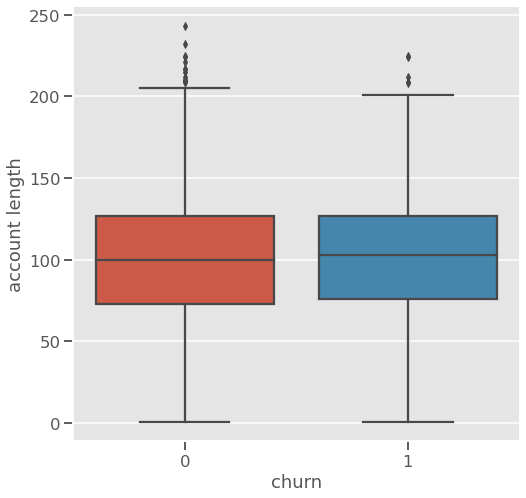

In [9]:
fig,ax = plt.subplots(figsize=(8,8))
sns.boxplot(data=s_tel,x='churn',y='account length');

Null Hypothesis: There is no significant difference in account length for customers that have churned vs. customers that have not churned.

Alternate Hypothesis: There is a significant difference in account length for customers that have churned vs. customers that have not churned.

With an alpha value of 0.05, we fail to reject the null hypothesis.

In [10]:
# T-test to check whether the churned & not churned groups have different means
al_not_churned = s_tel[s_tel['churn']==0]['account length']
al_churned = s_tel[s_tel['churn']==1]['account length']
stats.ttest_ind(al_not_churned, al_churned,equal_var=False)

Ttest_indResult(statistic=-0.9618893197561772, pvalue=0.33645751767927445)

<h3>International Plan</h3>

Based on these figures, whether the customer has an international plan does appear to be a good predictor of churn. There is no t-test for this because International Plan is a boolean feature.

In [11]:
print(s_tel.groupby('international plan')['churn'].agg(np.mean))
print(s_tel.groupby('international plan')['churn'].agg(np.std))

international plan
no     0.114950
yes    0.424149
Name: churn, dtype: float64
international plan
no     0.319015
yes    0.494980
Name: churn, dtype: float64


<h3>Voice Mail Plan</h3>

Based on these figures, whether the customer has a voice mail plan does appear to be a good predictor of churn. There is no t-test for this because Coice Mail Plan is a boolean feature.

In [12]:
print(s_tel.groupby('voice mail plan')['churn'].agg(np.mean))
print(s_tel.groupby('voice mail plan')['churn'].agg(np.std))

voice mail plan
no     0.167151
yes    0.086768
Name: churn, dtype: float64
voice mail plan
no     0.373188
yes    0.281647
Name: churn, dtype: float64


<h3>Number Voicemail Messages</h3>

Looking at both the boxplot and the results of the t-test, number of voice mail messages does seem to be a promising predictor of churn. We reject the null hypothesis meaning the means of the churn and not-churn groups are significantly different.

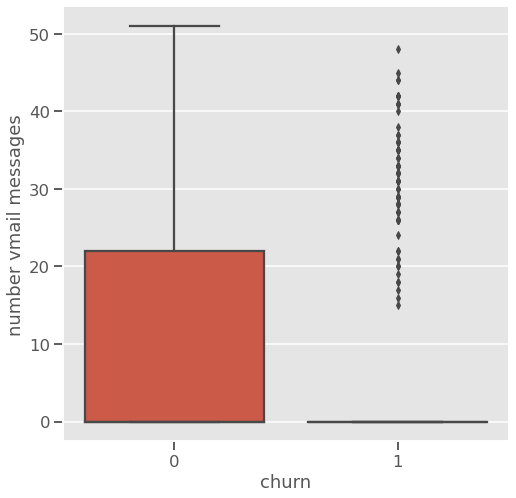

In [13]:
fig,ax = plt.subplots(figsize=(8,8))
sns.boxplot(data=s_tel,x='churn',y='number vmail messages');

Null Hypothesis: There is no significant difference in number of voice mail messages for customers that have churned vs. customers that have not churned.

Alternate Hypothesis: There is a significant difference in number of voice mail messages for customers that have churned vs. customers that have not churned.

With an alpha value of 0.05, we reject the null hypothesis.

In [14]:
# T-test to check whether the churned & not churned groups have different means
vm_not_churned = s_tel[s_tel['churn']==0]['number vmail messages']
vm_churned = s_tel[s_tel['churn']==1]['number vmail messages']
stats.ttest_ind(vm_not_churned, vm_churned,equal_var=False)

Ttest_indResult(statistic=5.821253623286179, pvalue=8.76478218022036e-09)

<h3>Total Day Calls</h3>

Looking at both the boxplot and the results of the t-test, total day calls does not seem to be a promising predictor of churn. We fail to reject the null hypothesis meaning the means of the churn and not-churn groups are not significantly different.

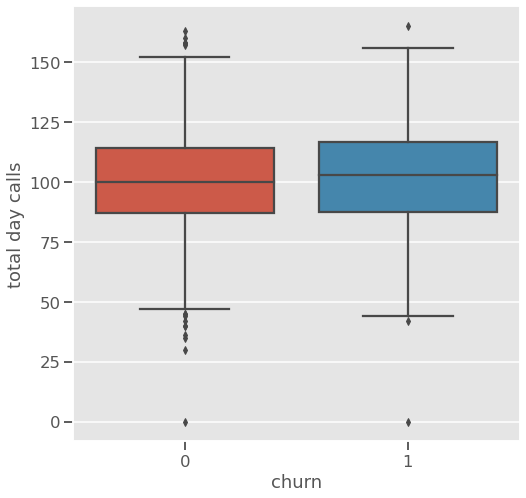

In [15]:
fig,ax = plt.subplots(figsize=(8,8))
sns.boxplot(data=s_tel,x='churn',y='total day calls');

Null Hypothesis: There is no significant difference in total day calls for customers that have churned vs. customers that have not churned.

Alternate Hypothesis: There is a significant difference in total day calls for customers that have churned vs. customers that have not churned.

With an alpha value of 0.05, we fail to reject the null hypothesis.

In [16]:
# T-test to check whether the churned & not churned groups have different means
dc_not_churned = s_tel[s_tel['churn']==0]['total day calls']
dc_churned = s_tel[s_tel['churn']==1]['total day calls']
stats.ttest_ind(dc_not_churned, dc_churned,equal_var=False)

Ttest_indResult(statistic=-1.0023867230811039, pvalue=0.316543431358623)

<h3>Total Day Charge</h3>

Looking at both the boxplot and the results of the t-test, total day charge does seem to be a promising predictor of churn. We reject the null hypothesis meaning the means of the churn and not-churn groups are significantly different.

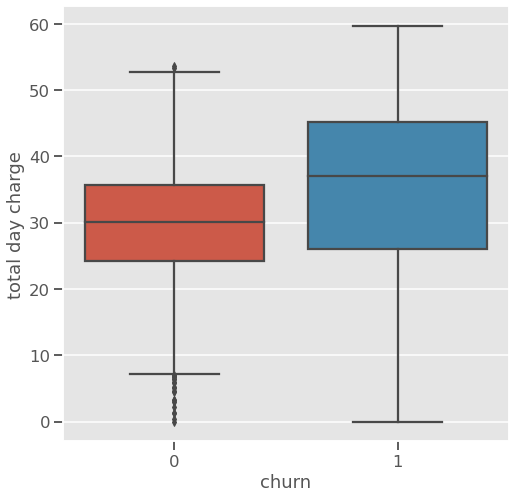

In [17]:
fig,ax = plt.subplots(figsize=(8,8))
sns.boxplot(data=s_tel,x='churn',y='total day charge');

Null Hypothesis: There is no significant difference in total day charge for customers that have churned vs. customers that have not churned.

Alternate Hypothesis: There is a significant difference in total day charge for customers that have churned vs. customers that have not churned.

With an alpha value of 0.05, we reject the null hypothesis.

In [18]:
# T-test to check whether the churned & not churned groups have different means
dchg_not_churned = s_tel[s_tel['churn']==0]['total day charge']
dchg_churned = s_tel[s_tel['churn']==1]['total day charge']
stats.ttest_ind(dchg_not_churned, dchg_churned,equal_var=False)

Ttest_indResult(statistic=-9.684475930233658, pvalue=1.2198763860802676e-20)

<h3>Total Eve Calls</h3>

Looking at both the boxplot and the results of the t-test, total eve calls does not seem to be a promising predictor of churn. We fail to reject the null hypothesis meaning the means of the churn and not-churn groups are not significantly different.

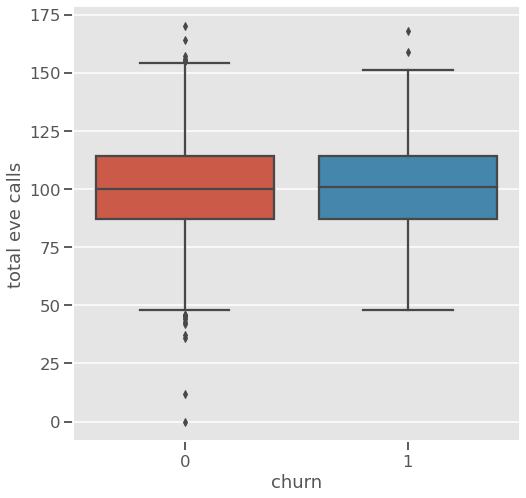

In [19]:
fig,ax = plt.subplots(figsize=(8,8))
sns.boxplot(data=s_tel,x='churn',y='total eve calls');

Null Hypothesis: There is no significant difference in total eve calls for customers that have churned vs. customers that have not churned.

Alternate Hypothesis: There is a significant difference in total eve calls for customers that have churned vs. customers that have not churned.

With an alpha value of 0.05, we fail to reject the null hypothesis.

In [20]:
# T-test to check whether the churned & not churned groups have different means
ec_not_churned = s_tel[s_tel['churn']==0]['total eve calls']
ec_churned = s_tel[s_tel['churn']==1]['total eve calls']
stats.ttest_ind(ec_not_churned, ec_churned,equal_var=False)

Ttest_indResult(statistic=-0.537388864584388, pvalue=0.5911800500990859)

<h3>Total Eve Charge</h3>

Looking at both the boxplot and the results of the t-test, total eve charge does seem to be a promising predictor of churn. We reject the null hypothesis meaning the means of the churn and not-churn groups are significantly different.

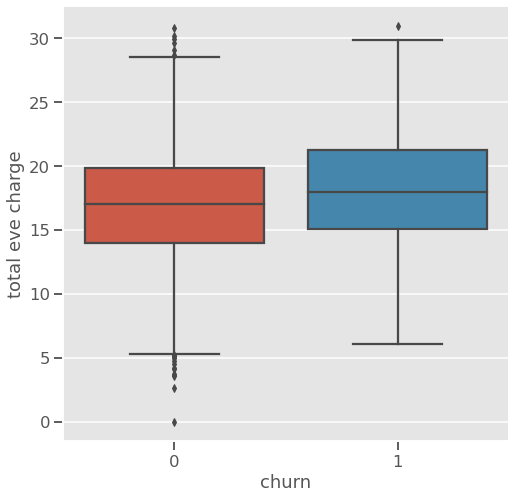

In [21]:
fig,ax = plt.subplots(figsize=(8,8))
sns.boxplot(data=s_tel,x='churn',y='total eve charge');

Null Hypothesis: There is no significant difference in total eve charge for customers that have churned vs. customers that have not churned.

Alternate Hypothesis: There is a significant difference in total eve charge for customers that have churned vs. customers that have not churned.

With an alpha value of 0.05, we reject the null hypothesis.

In [22]:
# T-test to check whether the churned & not churned groups have different means
echg_not_churned = s_tel[s_tel['churn']==0]['total eve charge']
echg_churned = s_tel[s_tel['churn']==1]['total eve charge']
stats.ttest_ind(echg_not_churned, echg_churned,equal_var=False)

Ttest_indResult(statistic=-5.271985823981345, pvalue=1.8426075435722568e-07)

<h3>Total Night Calls</h3>

Looking at both the boxplot and the results of the t-test, total night calls does not seem to be a promising predictor of churn. We fail to reject the null hypothesis meaning the means of the churn and not-churn groups are not significantly different.

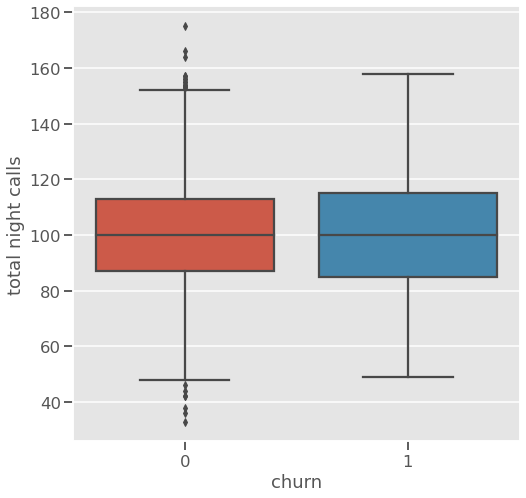

In [23]:
fig,ax = plt.subplots(figsize=(8,8))
sns.boxplot(data=s_tel,x='churn',y='total night calls');

Null Hypothesis: There is no significant difference in total eve calls for customers that have churned vs. customers that have not churned.

Alternate Hypothesis: There is a significant difference in total eve calls for customers that have churned vs. customers that have not churned.

With an alpha value of 0.05, we fail to reject the null hypothesis.

In [24]:
# T-test to check whether the churned & not churned groups have different means
nc_not_churned = s_tel[s_tel['churn']==0]['total night calls']
nc_churned = s_tel[s_tel['churn']==1]['total night calls']
stats.ttest_ind(nc_not_churned, nc_churned,equal_var=False)

Ttest_indResult(statistic=-0.34881843194709833, pvalue=0.7273389409976107)

<h3>Total Night Charge</h3>

Looking at both the boxplot and the results of the t-test, total night charge does seem to be a promising predictor of churn. We reject the null hypothesis meaning the means of the churn and not-churn groups are significantly different.

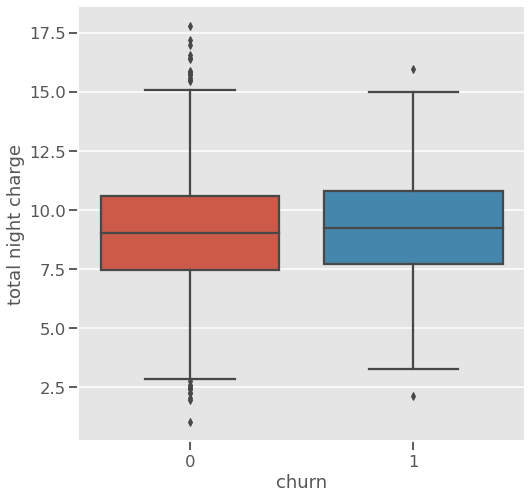

In [25]:
fig,ax = plt.subplots(figsize=(8,8))
sns.boxplot(data=s_tel,x='churn',y='total night charge');

Null Hypothesis: There is no significant difference in total night charge for customers that have churned vs. customers that have not churned.

Alternate Hypothesis: There is a significant difference in total night charge for customers that have churned vs. customers that have not churned.

With an alpha value of 0.05, we reject the null hypothesis.

In [26]:
# T-test to check whether the churned & not churned groups have different means
nchg_not_churned = s_tel[s_tel['churn']==0]['total night charge']
nchg_churned = s_tel[s_tel['churn']==1]['total night charge']
stats.ttest_ind(nchg_not_churned, nchg_churned,equal_var=False)

Ttest_indResult(statistic=-2.171006887437526, pvalue=0.030271539217208626)

<h3>Total Intl Calls</h3>

Looking at both the boxplot and the results of the t-test, total intl calls does seem to be a promising predictor of churn. We reject the null hypothesis meaning the means of the churn and not-churn groups are significantly different.

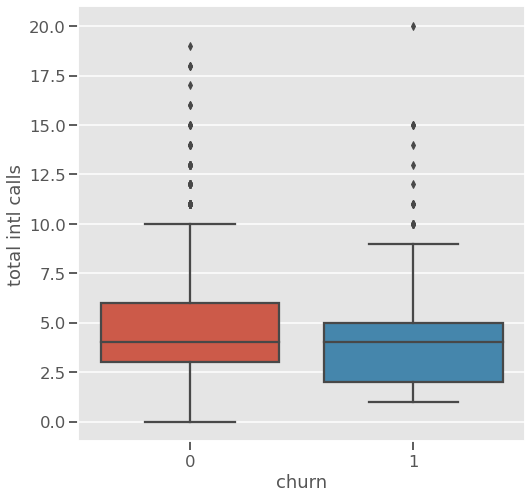

In [27]:
fig,ax = plt.subplots(figsize=(8,8))
sns.boxplot(data=s_tel,x='churn',y='total intl calls');

Null Hypothesis: There is no significant difference in total intl calls for customers that have churned vs. customers that have not churned.

Alternate Hypothesis: There is a significant difference in total intl calls for customers that have churned vs. customers that have not churned.

With an alpha value of 0.05, we reject the null hypothesis.

In [28]:
# T-test to check whether the churned & not churned groups have different means
ic_not_churned = s_tel[s_tel['churn']==0]['total intl calls']
ic_churned = s_tel[s_tel['churn']==1]['total intl calls']
stats.ttest_ind(ic_not_churned, ic_churned,equal_var=False)

Ttest_indResult(statistic=2.9604196334383635, pvalue=0.003185776922903233)

<h3>Total Intl Charge</h3>

Looking at both the boxplot and the results of the t-test, total intl charge does seem to be a promising predictor of churn. We reject the null hypothesis meaning the means of the churn and not-churn groups are significantly different. 

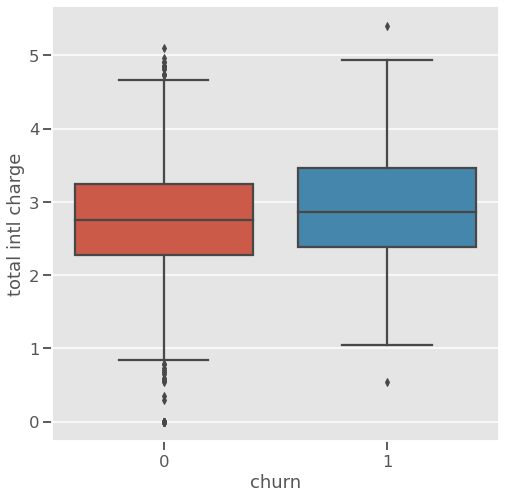

In [29]:
fig,ax = plt.subplots(figsize=(8,8))
sns.boxplot(data=s_tel,x='churn',y='total intl charge');

Null Hypothesis: There is no significant difference in total intl charge for customers that have churned vs. customers that have not churned.

Alternate Hypothesis: There is a significant difference in total intl charge for customers that have churned vs. customers that have not churned.

With an alpha value of 0.05, we reject the null hypothesis.

In [30]:
# T-test to check whether the churned & not churned groups have different means
ichg_not_churned = s_tel[s_tel['churn']==0]['total intl charge']
ichg_churned = s_tel[s_tel['churn']==1]['total intl charge']
stats.ttest_ind(ichg_not_churned, ichg_churned,equal_var=False)

Ttest_indResult(statistic=-3.939933040077332, pvalue=9.025886559180106e-05)

<h3>Customer Service Calls</h3>

Looking at both the boxplot and the results of the t-test, total customer service calls does seem to be a promising predictor of churn. We reject the null hypothesis meaning the means of the churn and not-churn groups are significantly different.

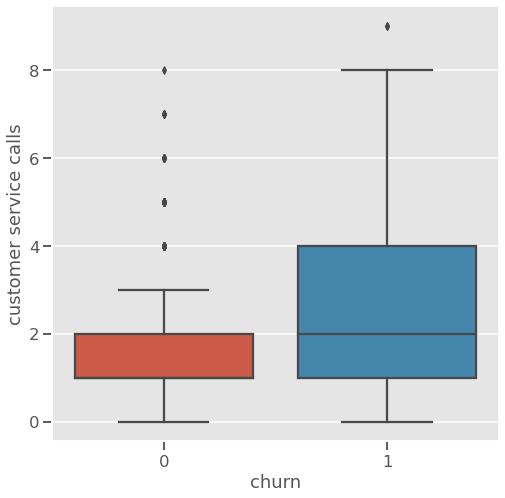

In [31]:
fig,ax = plt.subplots(figsize=(8,8))
sns.boxplot(data=s_tel,x='churn',y='customer service calls');

Null Hypothesis: There is no significant difference in cusomer service calls for customers that have churned vs. customers that have not churned.

Alternate Hypothesis: There is a significant difference in customer service calls for customers that have churned vs. customers that have not churned.

With an alpha value of 0.05, we reject the null hypothesis.

In [32]:
# T-test to check whether the churned & not churned groups have different means
cs_not_churned = s_tel[s_tel['churn']==0]['customer service calls']
cs_churned = s_tel[s_tel['churn']==1]['customer service calls']
stats.ttest_ind(cs_not_churned, cs_churned,equal_var=False)

Ttest_indResult(statistic=-8.95514138244338, pvalue=5.270040385717215e-18)

<h2>EDA Summary</h2>

I have grouped the features as followed based on the plots and statistical tests above. 

Target:
<ul><li>churn</ul>

Dropping Duplicates:
<ul><li>total day minutes
<li>total eve minutes
<li>total night minutes
<li>total intl minutes</ul>

Less Useful / Consider Dropping:
<ul><li>state
<li>account length
<li>total day calls
<li>total eve calls
<li>total night calls</ul>

Useful:
<ul><li>international plan
<li>voice mail plan
<li>number vmail messages
<li>total day charge
<li>total eve charge
<li>total night charge
<li>total intl calls
<li>total intl charge
<li>customer service calls</ul>

<h1>Feature Engineering</h1>

I will create new features which may be useful for predicting whether a customer will churn.

<h2>Total Charge

Looking at both the boxplot and the results of the t-test, total charge does seem to be a promising predictor of churn. We reject the null hypothesis meaning the means of the churn and not-churn groups are significantly different.

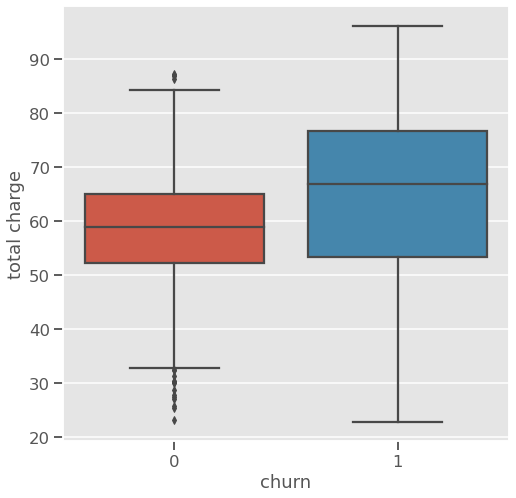

In [33]:
# Add all of the separate charge columns together
s_tel['total charge'] = s_tel['total day charge'] + s_tel['total eve charge']\
                        + s_tel['total night charge'] + s_tel['total intl charge']

fig,ax = plt.subplots(figsize=(8,8))
sns.boxplot(data=s_tel,x='churn',y='total charge');

Null Hypothesis: There is no significant difference in total charge for customers that have churned vs. customers that have not churned.

Alternate Hypothesis: There is a significant difference in total charge for customers that have churned vs. customers that have not churned.

With an alpha value of 0.05, we reject the null hypothesis.

In [34]:
# T-test to check whether the churned & not churned groups have different means
tchg_not_churned = s_tel[s_tel['churn']==0]['total charge']
tchg_churned = s_tel[s_tel['churn']==1]['total charge']
stats.ttest_ind(tchg_not_churned, tchg_churned,equal_var=False)

Ttest_indResult(statistic=-10.52641998294255, pvalue=9.114972608480988e-24)

<h2>Total Calls</h2>

Looking at both the boxplot and the results of the t-test, total calls does not seem to be a promising predictor of churn. We fail to reject the null hypothesis meaning the means of the churn and not-churn groups are not significantly different.

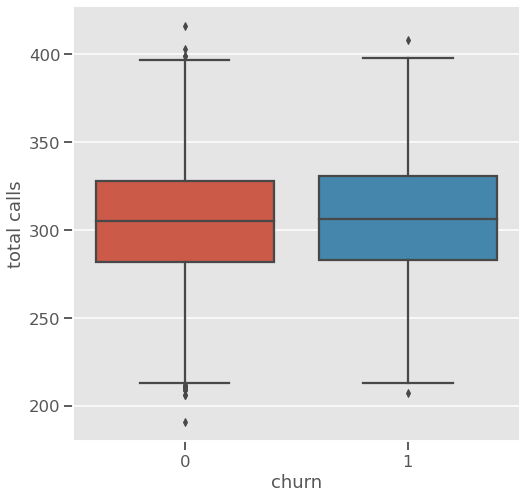

In [35]:
# Add all of the separate calls columns together
s_tel['total calls'] = s_tel['total day calls'] + s_tel['total eve calls']\
                        + s_tel['total night calls'] + s_tel['total intl calls']

fig,ax = plt.subplots(figsize=(8,8))
sns.boxplot(data=s_tel,x='churn',y='total calls');

Null Hypothesis: There is no significant difference in total calls for customers that have churned vs. customers that have not churned.

Alternate Hypothesis: There is a significant difference in total calls for customers that have churned vs. customers that have not churned.

With an alpha value of 0.05, we fail to reject the null hypothesis.

In [36]:
# T-test to check whether the churned & not churned groups have different means
tcal_not_churned = s_tel[s_tel['churn']==0]['total calls']
tcal_churned = s_tel[s_tel['churn']==1]['total calls']
stats.ttest_ind(tcal_not_churned, tcal_churned,equal_var=False)

Ttest_indResult(statistic=-0.8953848461813889, pvalue=0.3709146133345268)

<h1>Modeling Preparation</h1>

Here, I make a class to save all of the models I generate along with their results on the training data and cross validation. This will be useful when comparing models later.

In [37]:
# Dictionary for storing completed models
saved_models = {}

In [38]:
# Scoring for cross validation
scoring = {'Acc':'accuracy',
            'Prec':'precision',
            'Rec':'recall',
            'F1':'f1',
            'AUC':'roc_auc'}

class Saved_Model():

    def __init__(self, model, model_name,  X, y):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        self.cv_results = None
        
        # Cross validate and train the model on the X and y passed into the class
        self.cross_validate()
        self.train()  

    def __repr__(self):
        return f'Recall Score: {self.rec_mean:.3f}'

    def cross_validate(self, folds=10):
        # Cross validate the model with X and y passed into the class
        self.cv_results = cross_validate(self.model,self.X,self.y,cv=folds,scoring=scoring)

        # Accuracy results
        self.acc_mean = np.mean(self.cv_results['test_Acc'])
        self.acc_std = np.std(self.cv_results['test_Acc'])

        # Precision results
        self.prec_mean = np.mean(self.cv_results['test_Prec'])
        self.prec_std = np.std(self.cv_results['test_Prec'])

        # Recall results
        self.rec_mean = np.mean(self.cv_results['test_Rec'])
        self.rec_std = np.std(self.cv_results['test_Rec'])

        # F1 results
        self.f1_mean = np.mean(self.cv_results['test_F1'])
        self.f1_std = np.std(self.cv_results['test_F1'])

        # ROC AUC results
        self.auc_mean = np.mean(self.cv_results['test_AUC'])
        self.auc_std = np.std(self.cv_results['test_AUC'])

    def train(self):
        # Fits the model and generates predictions on the full X set
        self.model.fit(self.X,self.y)
        self.yhat = self.model.predict(self.X)

        # Calculates accuracy, precision, recall, and F1 on the full X set
        self.train_acc = accuracy_score(self.y,self.yhat)
        self.train_prec = precision_score(self.y,self.yhat)
        self.train_rec = recall_score(self.y,self.yhat)
        self.train_f1 = f1_score(self.y,self.yhat)
        self.train_auc = roc_auc_score(self.y,self.yhat)

    def summary(self):

        # Generate strings for training results
        train_title = f'Training Results for {self.name}:'
        train_acc = f'Training Accuracy: {self.train_acc:.3f}'
        train_prec = f'Training Precision: {self.train_prec:.3f}'
        train_rec = f'Training Recall: {self.train_rec:.3f}'
        train_f1 = f'Training F1: {self.train_f1:.3f}'
        train_auc = f'Training AUC: {self.train_auc:.3f}'

        breaker = ''

        # Generate strings for cross validation results
        cv_title = f'Cross Validation results for {self.name}:'
        cv_accuracy = f'CV Accuracy: Mean = {self.acc_mean:.3f} Std = {self.acc_std:.3f}'
        cv_precision = f'CV Precision: Mean = {self.prec_mean:.3f} Std = {self.prec_std:.3f}'
        cv_recall = f'CV Recall: Mean = {self.rec_mean:.3f} Std = {self.rec_std:.3f}'
        cv_f1 = f'CV F1: Mean = {self.f1_mean:.3f} Std = {self.f1_std:.3f}'
        cv_auc = f'CV AUC: Mean = {self.auc_mean:.3f} Std = {self.auc_std:.3f}'

        # Print the summary
        for line in [train_title,train_acc,train_prec,train_rec,train_f1,train_auc,
                     breaker,cv_title,cv_accuracy,cv_precision,cv_recall,cv_f1,cv_auc]:
            print(line)


<h1>Train Test Split</h1>

In [39]:
X = s_tel.drop('churn',axis=1)
y = s_tel.churn

# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8,random_state=42,stratify=y)

<h1>Preliminary Modeling</h1>

I will being by testing a variety of models using their default settings. I will attempt to correct for the ~6:1 class imbalence using both class weights and SMOTE where appropriate. This will help me determine which models I should focus on optimizing later.

I use the following models:
<ol>
<li>Logistic Regression
<li>Decision Tree
<li>K Neighbors
<li>Extra Trees
<li>Random Forest
<li>AdaBoost
<li>XGBoost
</ol>

In [40]:
drop_preliminary = ['total day minutes','total eve minutes','total night minutes','total intl minutes','state']

# Group the columns by the transformer they should use
ordinal_cols = ['international plan','voice mail plan']
numerical_cols = X.drop(ordinal_cols+drop_preliminary,axis=1).columns

# Create a column transformer with a relevant transformer for each of the above groups
preliminary_column_transformer = ColumnTransformer(transformers=[
    ('ORD',OrdinalEncoder(categories='auto'),ordinal_cols),
    ('STD',StandardScaler(),numerical_cols)
    ],
    # Drop the columns not assigned a transformer
    remainder='drop')

# International and VMail plans are bools
smote = SMOTENC(random_state=42,categorical_features=[1,2])

<h2>Logistic Regression</h2>

<h3>Using Class Weights

In [41]:
# Creates a pipeline for the model
pipeline_logistic_regression_cw = Pipeline(steps=[
    ('ct',preliminary_column_transformer),
    ('log_regression',LogisticRegression(random_state=42,class_weight='balanced'))
    ])

# Creates a saved model object using the pipeline 
# This trains and cross validates the pipeline
model_logistic_regression_cw = Saved_Model(pipeline_logistic_regression_cw,
                                        'Logistic Regression - CW', X_train,y_train)

# Adds the trained model to the saved models dict                                            
saved_models[model_logistic_regression_cw.name] = model_logistic_regression_cw

# Print summary stats for the model
model_logistic_regression_cw.summary()

Training Results for Logistic Regression - CW:
Training Accuracy: 0.773
Training Precision: 0.364
Training Recall: 0.762
Training F1: 0.492
Training AUC: 0.768

Cross Validation results for Logistic Regression - CW:
CV Accuracy: Mean = 0.766 Std = 0.018
CV Precision: Mean = 0.354 Std = 0.030
CV Recall: Mean = 0.752 Std = 0.088
CV F1: Mean = 0.481 Std = 0.044
CV AUC: Mean = 0.819 Std = 0.035


<h3>Using SMOTE

In [42]:
# Creates a pipeline for the model
pipeline_logistic_regression_smote = imbPipeline(steps=[
    ('ct',preliminary_column_transformer),
    ('smote',smote),
    ('log_regression',LogisticRegression(random_state=42))
    ])

# Creates a saved model object using the pipeline 
# This trains and cross validates the pipeline
model_logistic_regression_smote = Saved_Model(pipeline_logistic_regression_smote,
                                            'Logistic Regression - SMOTE',X_train,y_train)

# Adds the trained model to the saved models dict  
saved_models[model_logistic_regression_smote.name] = model_logistic_regression_smote

# Print summary stats for the model
model_logistic_regression_smote.summary()

Training Results for Logistic Regression - SMOTE:
Training Accuracy: 0.775
Training Precision: 0.364
Training Recall: 0.746
Training F1: 0.489
Training AUC: 0.763

Cross Validation results for Logistic Regression - SMOTE:
CV Accuracy: Mean = 0.769 Std = 0.016
CV Precision: Mean = 0.357 Std = 0.029
CV Recall: Mean = 0.744 Std = 0.092
CV F1: Mean = 0.482 Std = 0.044
CV AUC: Mean = 0.818 Std = 0.034


<h2>Decision Tree</h2>

<h3>Using Class Weights

In [43]:
# Creates a pipeline for the model
pipeline_decision_tree_cw = Pipeline(steps=[
    ('ct',preliminary_column_transformer),
    ('decision tree',DecisionTreeClassifier(random_state=42,class_weight='balanced'))
    ])

# Creates a saved model object using the pipeline 
# This trains and cross validates the pipeline
model_decision_tree_cw = Saved_Model(pipeline_decision_tree_cw,
                                    'Decision Tree - CW',X_train,y_train)

# Adds the trained model to the saved models dict  
saved_models[model_decision_tree_cw.name] = model_decision_tree_cw

# Print summary stats for the model
model_decision_tree_cw.summary()

Training Results for Decision Tree - CW:
Training Accuracy: 1.000
Training Precision: 1.000
Training Recall: 1.000
Training F1: 1.000
Training AUC: 1.000

Cross Validation results for Decision Tree - CW:
CV Accuracy: Mean = 0.964 Std = 0.010
CV Precision: Mean = 0.890 Std = 0.046
CV Recall: Mean = 0.860 Std = 0.056
CV F1: Mean = 0.873 Std = 0.038
CV AUC: Mean = 0.921 Std = 0.028


<h3>Using SMOTE

In [44]:
# Creates a pipeline for the model
pipeline_decision_tree_smote = imbPipeline(steps=[
    ('ct',preliminary_column_transformer),
    ('smote',smote),
    ('decision tree',DecisionTreeClassifier(random_state=42))
    ])

# Creates a saved model object using the pipeline 
# This trains and cross validates the pipeline
model_decision_tree_smote = Saved_Model(pipeline_decision_tree_smote,
                                    'Decision Tree - SMOTE',X_train,y_train)

# Adds the trained model to the saved models dict  
saved_models[model_decision_tree_smote.name] = model_decision_tree_smote

# Print summary stats for the model
model_decision_tree_smote.summary()

Training Results for Decision Tree - SMOTE:
Training Accuracy: 1.000
Training Precision: 1.000
Training Recall: 1.000
Training F1: 1.000
Training AUC: 1.000

Cross Validation results for Decision Tree - SMOTE:
CV Accuracy: Mean = 0.935 Std = 0.019
CV Precision: Mean = 0.740 Std = 0.077
CV Recall: Mean = 0.870 Std = 0.046
CV F1: Mean = 0.797 Std = 0.051
CV AUC: Mean = 0.908 Std = 0.025


<h2>K Neighbors

<h3>No Class Weight Parameter

In [45]:
# Creates a pipeline for the model
pipeline_knn_vanilla = Pipeline(steps=[
    ('ct',preliminary_column_transformer),
    ('knn',KNeighborsClassifier(n_neighbors=3))
    ])

# Creates a saved model object using the pipeline 
# This trains and cross validates the pipeline
model_knn_vanilla = Saved_Model(pipeline_knn_vanilla,
                                'KNN - Vanilla',X_train,y_train)

# Adds the trained model to the saved models dict  
saved_models[model_knn_vanilla.name] = model_knn_vanilla

# Print summary stats for the model
model_knn_vanilla.summary()

Training Results for KNN - Vanilla:
Training Accuracy: 0.937
Training Precision: 0.939
Training Recall: 0.601
Training F1: 0.733
Training AUC: 0.797

Cross Validation results for KNN - Vanilla:
CV Accuracy: Mean = 0.892 Std = 0.011
CV Precision: Mean = 0.769 Std = 0.085
CV Recall: Mean = 0.370 Std = 0.062
CV F1: Mean = 0.497 Std = 0.064
CV AUC: Mean = 0.774 Std = 0.036


<h3>Using Smote

In [46]:
# Creates a pipeline for the model
pipeline_knn_smote = imbPipeline(steps=[
    ('ct',preliminary_column_transformer),
    ('smote',smote),
    ('knn',KNeighborsClassifier(n_neighbors=3))
    ])

# Creates a saved model object using the pipeline 
# This trains and cross validates the pipeline
model_knn_smote = Saved_Model(pipeline_knn_smote,
                            'KNN - SMOTE',X_train,y_train)

# Adds the trained model to the saved models dict  
saved_models[model_knn_smote.name] = model_knn_smote

# Print summary stats for the model
model_knn_smote.summary()

Training Results for KNN - SMOTE:
Training Accuracy: 0.924
Training Precision: 0.657
Training Recall: 0.992
Training F1: 0.791
Training AUC: 0.952

Cross Validation results for KNN - SMOTE:
CV Accuracy: Mean = 0.814 Std = 0.013
CV Precision: Mean = 0.415 Std = 0.028
CV Recall: Mean = 0.697 Std = 0.069
CV F1: Mean = 0.520 Std = 0.038
CV AUC: Mean = 0.787 Std = 0.038


<h1>Extra Trees

<h3>Using Class Weights

In [47]:
# Creates a pipeline for the model
pipeline_extra_trees_cw = Pipeline(steps=[
    ('ct',preliminary_column_transformer),
    ('extra',ExtraTreesClassifier(random_state=42,class_weight='balanced'))
    ])

# Creates a saved model object using the pipeline 
# This trains and cross validates the pipeline
model_extra_trees_cw = Saved_Model(pipeline_extra_trees_cw,
                                    'Extra Trees - CW',X_train,y_train)

# Adds the trained model to the saved models dict  
saved_models[model_extra_trees_cw.name] = model_extra_trees_cw

# Print summary stats for the model
model_extra_trees_cw.summary()

Training Results for Extra Trees - CW:
Training Accuracy: 1.000
Training Precision: 1.000
Training Recall: 1.000
Training F1: 1.000
Training AUC: 1.000

Cross Validation results for Extra Trees - CW:
CV Accuracy: Mean = 0.938 Std = 0.009
CV Precision: Mean = 0.967 Std = 0.031
CV Recall: Mean = 0.591 Std = 0.063
CV F1: Mean = 0.731 Std = 0.049
CV AUC: Mean = 0.916 Std = 0.037


<h3>Using SMOTE

In [48]:
# Creates a pipeline for the model
pipeline_extra_trees_smote = imbPipeline(steps=[
    ('ct',preliminary_column_transformer),
    ('smote',smote),
    ('extra',ExtraTreesClassifier(random_state=42))
    ])

# Creates a saved model object using the pipeline 
# This trains and cross validates the pipeline
model_extra_trees_smote = Saved_Model(pipeline_extra_trees_smote,
                                    'Extra Trees - SMOTE',X_train,y_train)

# Adds the trained model to the saved models dict  
saved_models[model_extra_trees_smote.name] = model_extra_trees_smote

# Print summary stats for the model
model_extra_trees_smote.summary()

Training Results for Extra Trees - SMOTE:
Training Accuracy: 1.000
Training Precision: 1.000
Training Recall: 1.000
Training F1: 1.000
Training AUC: 1.000

Cross Validation results for Extra Trees - SMOTE:
CV Accuracy: Mean = 0.948 Std = 0.009
CV Precision: Mean = 0.874 Std = 0.046
CV Recall: Mean = 0.751 Std = 0.048
CV F1: Mean = 0.806 Std = 0.033
CV AUC: Mean = 0.922 Std = 0.031


<h2>Random Forest

<h3>Using Class Weights

In [49]:
# Creates a pipeline for the model
pipeline_random_forest_cw = Pipeline(steps=[
    ('ct',preliminary_column_transformer),
    ('forest',RandomForestClassifier(random_state=42,class_weight='balanced'))
    ])

# Creates a saved model object using the pipeline 
# This trains and cross validates the pipeline
model_random_forest_cw = Saved_Model(pipeline_random_forest_cw,
                                    'Random Forest - CW',X_train,y_train)
                                    
# Adds the trained model to the saved models dict  
saved_models[model_random_forest_cw.name] = model_random_forest_cw

# Print summary stats for the model
model_random_forest_cw.summary()

Training Results for Random Forest - CW:
Training Accuracy: 1.000
Training Precision: 1.000
Training Recall: 1.000
Training F1: 1.000
Training AUC: 1.000

Cross Validation results for Random Forest - CW:
CV Accuracy: Mean = 0.970 Std = 0.011
CV Precision: Mean = 1.000 Std = 0.000
CV Recall: Mean = 0.790 Std = 0.073
CV F1: Mean = 0.881 Std = 0.046
CV AUC: Mean = 0.921 Std = 0.037


<h3>Using SMOTE

In [50]:
# Creates a pipeline for the model
pipeline_random_forest_smote = imbPipeline(steps=[
    ('ct',preliminary_column_transformer),
    ('smote',smote),
    ('forest',RandomForestClassifier(random_state=42))
    ])

# Creates a saved model object using the pipeline 
# This trains and cross validates the pipeline
model_random_forest_smote = Saved_Model(pipeline_random_forest_smote,
                                    'Random Forest - SMOTE',X_train,y_train)

# Adds the trained model to the saved models dict  
saved_models[model_random_forest_smote.name] = model_random_forest_smote

# Print summary stats for the model
model_random_forest_smote.summary()

Training Results for Random Forest - SMOTE:
Training Accuracy: 1.000
Training Precision: 1.000
Training Recall: 1.000
Training F1: 1.000
Training AUC: 1.000

Cross Validation results for Random Forest - SMOTE:
CV Accuracy: Mean = 0.976 Std = 0.007
CV Precision: Mean = 0.969 Std = 0.023
CV Recall: Mean = 0.860 Std = 0.056
CV F1: Mean = 0.910 Std = 0.030
CV AUC: Mean = 0.923 Std = 0.033


<h2>AdaBoost

<h3>No Class Weight Parameter

In [51]:
# Creates a pipeline for the model
pipeline_adaboost_vanilla = Pipeline(steps=[
    ('ct',preliminary_column_transformer),
    ('boost',AdaBoostClassifier(random_state=42))
    ])

# Creates a saved model object using the pipeline 
# This trains and cross validates the pipeline
model_adaboost_vanilla = Saved_Model(pipeline_adaboost_vanilla,
                                    'AdaBoost - Vanilla',X_train,y_train)

# Adds the trained model to the saved models dict  
saved_models[model_adaboost_vanilla.name] = model_adaboost_vanilla

# Print summary stats for the model
model_adaboost_vanilla.summary()

Training Results for AdaBoost - Vanilla:
Training Accuracy: 0.927
Training Precision: 0.828
Training Recall: 0.624
Training F1: 0.712
Training AUC: 0.801

Cross Validation results for AdaBoost - Vanilla:
CV Accuracy: Mean = 0.910 Std = 0.014
CV Precision: Mean = 0.763 Std = 0.066
CV Recall: Mean = 0.549 Std = 0.070
CV F1: Mean = 0.637 Std = 0.064
CV AUC: Mean = 0.886 Std = 0.037


<h3>Using SMOTE

In [52]:
# Creates a pipeline for the model
pipeline_adaboost_smote = imbPipeline(steps=[
    ('ct',preliminary_column_transformer),
    ('smote',smote),
    ('boost',AdaBoostClassifier(random_state=42))
    ])

# Creates a saved model object using the pipeline 
# This trains and cross validates the pipeline
model_adaboost_smote = Saved_Model(pipeline_adaboost_smote,
                                'AdaBoost - SMOTE',X_train,y_train)

# Adds the trained model to the saved models dict  
saved_models[model_adaboost_smote.name] = model_adaboost_smote

# Print summary stats for the model
model_adaboost_smote.summary()

Training Results for AdaBoost - SMOTE:
Training Accuracy: 0.907
Training Precision: 0.643
Training Recall: 0.803
Training F1: 0.714
Training AUC: 0.864

Cross Validation results for AdaBoost - SMOTE:
CV Accuracy: Mean = 0.898 Std = 0.017
CV Precision: Mean = 0.619 Std = 0.054
CV Recall: Mean = 0.772 Std = 0.069
CV F1: Mean = 0.686 Std = 0.052
CV AUC: Mean = 0.893 Std = 0.032


<h1>XGBoost

<h3>No Class Weight Parameter

In [53]:
# Creates a pipeline for the model
pipeline_xgboost_vanilla = Pipeline(steps=[
    ('ct',preliminary_column_transformer),
    ('boost',xgb(seed=42))
    ])

# Creates a saved model object using the pipeline 
# This trains and cross validates the pipeline
model_xgboost_vanilla = Saved_Model(pipeline_xgboost_vanilla,
                            'XGBoost - Vanilla',X_train,y_train)

# Adds the trained model to the saved models dict  
saved_models[model_xgboost_vanilla.name] = model_xgboost_vanilla

# Print summary stats for the model
model_xgboost_vanilla.summary()

Training Results for XGBoost - Vanilla:
Training Accuracy: 1.000
Training Precision: 1.000
Training Recall: 1.000
Training F1: 1.000
Training AUC: 1.000

Cross Validation results for XGBoost - Vanilla:
CV Accuracy: Mean = 0.980 Std = 0.008
CV Precision: Mean = 1.000 Std = 0.000
CV Recall: Mean = 0.863 Std = 0.053
CV F1: Mean = 0.925 Std = 0.031
CV AUC: Mean = 0.918 Std = 0.033


<h3>Using SMOTE

In [54]:
# Creates a pipeline for the model
pipeline_xgboost_smote = imbPipeline(steps=[
    ('ct',preliminary_column_transformer),
    ('smote',smote),
    ('boost',xgb(seed=42))
    ])

# Creates a saved model object using the pipeline 
# This trains and cross validates the pipeline
model_xgboost_smote = Saved_Model(pipeline_xgboost_smote,
                            'XGBoost - SMOTE',X_train,y_train)

# Adds the trained model to the saved models dict  
saved_models[model_xgboost_smote.name] = model_xgboost_smote

# Print summary stats for the model
model_xgboost_smote.summary()

Training Results for XGBoost - SMOTE:
Training Accuracy: 1.000
Training Precision: 1.000
Training Recall: 1.000
Training F1: 1.000
Training AUC: 1.000

Cross Validation results for XGBoost - SMOTE:
CV Accuracy: Mean = 0.976 Std = 0.009
CV Precision: Mean = 0.965 Std = 0.026
CV Recall: Mean = 0.863 Std = 0.053
CV F1: Mean = 0.910 Std = 0.036
CV AUC: Mean = 0.927 Std = 0.032


<h1>Summary of Models So Far</h1>

Once again, the primary metric I am using to evaluate models is <b>Recall Score</b>.

Three models stand out:

<ul>
<li>Decision Tree
<li>Random Forest
<li>XGBoost
</ul>

I will forgo optimizing the decision tree in favor of the random forest because the random forest has more parameters I can tune. Both the random forest and XGBoost models performed better when using SMOTE than class weights so I will continue using SMOTE when optimizing the models further.

In [55]:
saved_models

{'Logistic Regression - CW': Recall Score: 0.752,
 'Logistic Regression - SMOTE': Recall Score: 0.744,
 'Decision Tree - CW': Recall Score: 0.860,
 'Decision Tree - SMOTE': Recall Score: 0.870,
 'KNN - Vanilla': Recall Score: 0.370,
 'KNN - SMOTE': Recall Score: 0.697,
 'Extra Trees - CW': Recall Score: 0.591,
 'Extra Trees - SMOTE': Recall Score: 0.751,
 'Random Forest - CW': Recall Score: 0.790,
 'Random Forest - SMOTE': Recall Score: 0.860,
 'AdaBoost - Vanilla': Recall Score: 0.549,
 'AdaBoost - SMOTE': Recall Score: 0.772,
 'XGBoost - Vanilla': Recall Score: 0.863,
 'XGBoost - SMOTE': Recall Score: 0.863}

<h1>Random Forest Tuning</h1>

The main problem with my random forest model is that it seems to be overfitting. This is evidenced by the scores on training being significantly higher than the scores on cross validation. I will attempt to address this by reducing the number of features my model has to train on and using a grid search to find the optimal hyperparemeters for the model.

In [56]:
model_random_forest_smote.summary()

Training Results for Random Forest - SMOTE:
Training Accuracy: 1.000
Training Precision: 1.000
Training Recall: 1.000
Training F1: 1.000
Training AUC: 1.000

Cross Validation results for Random Forest - SMOTE:
CV Accuracy: Mean = 0.976 Std = 0.007
CV Precision: Mean = 0.969 Std = 0.023
CV Recall: Mean = 0.860 Std = 0.056
CV F1: Mean = 0.910 Std = 0.030
CV AUC: Mean = 0.923 Std = 0.033


<h2>Feature Selection</h2>

I am selecting the features to drop based on the feature importances from the original random forest and my exploratory data analysis. I am then refitting a random forest on the new feature set and comparing the resutls to the original random forest. Feature selection does appear to improve the predictions of the model, but does not seem to be doing a lot about the overfitting problem.

In [57]:
# Gets the feature importances and zips them to the feature names
feature_importance_vals = model_random_forest_smote.model.named_steps['forest'].feature_importances_
feature_importances = dict(zip(ordinal_cols+list(numerical_cols),feature_importance_vals))

# Sorts the features by importance
feature_importances = dict(sorted(feature_importances.items(), key=lambda item: item[1]))
feature_importances

{'voice mail plan': 0.020826909746794783,
 'account length': 0.021027636128385128,
 'total night calls': 0.024984130469941794,
 'total eve calls': 0.026184220977357984,
 'total calls': 0.02700517081947429,
 'total day calls': 0.027281806082033268,
 'total night charge': 0.03002086323886274,
 'number vmail messages': 0.031274690029861774,
 'total eve charge': 0.0392951560659775,
 'total intl charge': 0.04103566587291534,
 'total intl calls': 0.062325763206146696,
 'total day charge': 0.11704797616172012,
 'international plan': 0.14516634154090086,
 'customer service calls': 0.1805882705893547,
 'total charge': 0.20593539907027317}

In [58]:
# Columns to drop based on FI and EDA
drop_forest = ['total day minutes','total eve minutes','total night minutes','total intl minutes',
                'total day calls','total eve calls','total night calls','state']

ordinal_cols = ['international plan','voice mail plan']
numerical_cols = X.drop(ordinal_cols+drop_forest,axis=1).columns

# Creates a new column transformer with the selected features
column_transformer_forest = ColumnTransformer(transformers=[
    ('ORD',OrdinalEncoder(categories='auto'),ordinal_cols),
    ('STD',StandardScaler(),numerical_cols)
    ],remainder='drop')

# New Smote instance because of different columns
smote_fst = SMOTENC(random_state=42,categorical_features=[1,2])

In [59]:
# Creates a pipeline for the model
pipeline_tuned_forest = imbPipeline(steps=[
    ('ct',column_transformer_forest),
    ('smote',smote_fst),
    ('forest',RandomForestClassifier(random_state=42,n_jobs=-1))
    ])

# Creates a saved model object using the pipeline 
# This trains and cross validates the pipeline
model_tuned_forest = Saved_Model(pipeline_tuned_forest,
                                'Random Forest - Feature Selection',X_train,y_train)

# Adds the trained model to the saved models dict  
saved_models[model_tuned_forest.name] = model_tuned_forest

# Print summary stats for the model
model_tuned_forest.summary()

Training Results for Random Forest - Feature Selection:
Training Accuracy: 1.000
Training Precision: 1.000
Training Recall: 1.000
Training F1: 1.000
Training AUC: 1.000

Cross Validation results for Random Forest - Feature Selection:
CV Accuracy: Mean = 0.980 Std = 0.008
CV Precision: Mean = 0.991 Std = 0.018
CV Recall: Mean = 0.868 Std = 0.056
CV F1: Mean = 0.924 Std = 0.034
CV AUC: Mean = 0.927 Std = 0.027


<h2>Grid Search</h2>

Here, I am using the new feature set and looping over a variety of hyperparameters of the random forest model. The main goal is to improve the model's predictions by reducing overfitting. This was relatively successful as the model's cross validation scores improved and got closer to the training data scores indicating the model is overfitting less.

This is the best I was able to get a random forest to perform.

In [60]:
# F Beta score is good here because I want to optimize for recall
# without throwing precision out the window (beta=2 prefers recall)
scorer = make_scorer(fbeta_score,beta=2)

# Grid of parameters to iterate over
forest_param_grid = {
    'forest__max_depth':[3,8,10,15,None],
    'forest__n_estimators':[50,100,150,200],
    'forest__min_samples_leaf':[1,2,4,8,16],
    'forest__max_features':[2,4,6,8]
}

# Creates the GridSearchCV object
grid_results_forest = GridSearchCV(estimator=pipeline_tuned_forest,scoring=scorer,cv=5,
                            param_grid=forest_param_grid)

# Iterates over parameters
grid_results_forest.fit(X_train,y_train)

# Return the best estimator with parameters
grid_results_forest.best_estimator_

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('ORD', OrdinalEncoder(),
                                                  ['international plan',
                                                   'voice mail plan']),
                                                 ('STD', StandardScaler(),
                                                  Index(['account length', 'number vmail messages', 'total day charge',
       'total eve charge', 'total night charge', 'total intl calls',
       'total intl charge', 'customer service calls', 'total charge',
       'total calls'],
      dtype='object'))])),
                ('smote',
                 SMOTENC(categorical_features=[1, 2], random_state=42)),
                ('forest',
                 RandomForestClassifier(max_depth=15, max_features=4,
                                        min_samples_leaf=8, n_estimators=150,
                                        n_jobs=-1, random_state=42))])

In [61]:
# Creates a saved model object using the pipeline 
# This trains and cross validates the pipeline
model_grid_search_forest = Saved_Model(grid_results_forest.best_estimator_,
                                        'Random Forest - Grid Search',X_train,y_train)

# Adds the trained model to the saved models dict  
saved_models[model_grid_search_forest.name] = model_grid_search_forest

# Print summary stats for the model
model_grid_search_forest.summary()

Training Results for Random Forest - Grid Search:
Training Accuracy: 0.982
Training Precision: 0.997
Training Recall: 0.878
Training F1: 0.934
Training AUC: 0.939

Cross Validation results for Random Forest - Grid Search:
CV Accuracy: Mean = 0.980 Std = 0.009
CV Precision: Mean = 0.991 Std = 0.019
CV Recall: Mean = 0.868 Std = 0.056
CV F1: Mean = 0.924 Std = 0.035
CV AUC: Mean = 0.930 Std = 0.032


<h1>XGBoost Tuning

The main problem with my XGBoost is that it seems to be overfitting. This is evidenced by the scores on training being significantly higher than the scores on cross validation. I will attempt to address this by reducing the number of features my model has to train on and using a grid search to find the optimal hyperparemeters for the model.

In [62]:
model_xgboost_smote.summary()

Training Results for XGBoost - SMOTE:
Training Accuracy: 1.000
Training Precision: 1.000
Training Recall: 1.000
Training F1: 1.000
Training AUC: 1.000

Cross Validation results for XGBoost - SMOTE:
CV Accuracy: Mean = 0.976 Std = 0.009
CV Precision: Mean = 0.965 Std = 0.026
CV Recall: Mean = 0.863 Std = 0.053
CV F1: Mean = 0.910 Std = 0.036
CV AUC: Mean = 0.927 Std = 0.032


<h2>Feature Selection</h2>

I am selecting the features to drop based on the feature importances from the original XGBoost model and my exploratory data analysis. I am then refitting an XGBoost model on the new feature set and comparing the resutls to the original XGBoost model. Feature selection does appear to improve the predictions of the model, but does not seem to be doing a lot about the overfitting problem.

In [63]:
# Gets the feature importances and zips them to the feature names
feature_importance_vals = model_xgboost_smote.model.named_steps['boost'].feature_importances_
feature_importances = dict(zip(ordinal_cols + list(numerical_cols),feature_importance_vals))

# Sorts the features by importance
feature_importances = dict(sorted(feature_importances.items(), key=lambda item: item[1]))
feature_importances

{'total eve charge': 0.010642742,
 'total day charge': 0.010658858,
 'total night charge': 0.011298176,
 'total intl calls': 0.012286907,
 'customer service calls': 0.013900946,
 'account length': 0.015573391,
 'total intl charge': 0.015700076,
 'total charge': 0.03730822,
 'total calls': 0.043410525,
 'number vmail messages': 0.052873276,
 'voice mail plan': 0.14064847,
 'international plan': 0.30780423}

In [64]:
# Columns to drop based on FI and EDA
drop_xgb = ['total day minutes','total eve minutes','total night minutes','total intl minutes',
                'total day calls','total eve calls','total night calls','total night charge',
                'voice mail plan','total calls','state']

ordinal_cols = ['international plan']
numerical_cols = X.drop(ordinal_cols+drop_xgb,axis=1).columns

# Creates a new column transformer with the selected features
column_transformer_xgb = ColumnTransformer(transformers=[
    ('ORD',OrdinalEncoder(categories='auto'),ordinal_cols),
    ('STD',StandardScaler(),numerical_cols)
    ],remainder='drop')

# New Smote instance because of different columns
smote_xgb = SMOTENC(random_state=42,categorical_features=[1])

In [65]:
# Creates a pipeline for the model
pipeline_tuned_xgb = imbPipeline(steps=[
    ('ct',column_transformer_xgb),
    ('smote',smote_xgb),
    ('boost',xgb(seed=42))
    ])

# Creates a saved model object using the pipeline 
# This trains and cross validates the pipeline
model_tuned_xgb = Saved_Model(pipeline_tuned_xgb,
                                'XGBoost - Feature Selection',X_train,y_train)

# Adds the trained model to the saved models dict  
saved_models[model_tuned_xgb.name] = model_tuned_xgb

# Print summary stats for the model
model_tuned_xgb.summary()

Training Results for XGBoost - Feature Selection:
Training Accuracy: 1.000
Training Precision: 1.000
Training Recall: 1.000
Training F1: 1.000
Training AUC: 1.000

Cross Validation results for XGBoost - Feature Selection:
CV Accuracy: Mean = 0.977 Std = 0.009
CV Precision: Mean = 0.976 Std = 0.022
CV Recall: Mean = 0.863 Std = 0.053
CV F1: Mean = 0.915 Std = 0.037
CV AUC: Mean = 0.922 Std = 0.033


<h2>Grid Search

Here, I am using the new feature set and looping over a variety of hyperparameters of the XGBoost model. The main goal is to improve the model's predictions by reducing overfitting. This was successful as the model's cross validation scores improved and got closer to the training data scores indicating the model is overfitting less.

This is the best I was able to get a model to perform.

In [66]:
# Grid of parameters to iterate over
xgb_param_grid = {
        'boost__max_depth':[2,4,6,8],
        'boost__reg_lambda':[1,5,10], # L2 Regularization
        'boost__learning_rate':[0.05,0.1,0.3,0.6,1],
        'boost__subsample':[.25,.5,.75,1],
        'boost__n_estimators':[50,100,200]
}

# Creates the GridSearchCV object
grid_results_xgb = GridSearchCV(estimator=pipeline_tuned_xgb,scoring=scorer,cv=5,
                            param_grid=xgb_param_grid)

# Iterates over parameters
grid_results_xgb.fit(X_train,y_train)
# Returns the best estimator with parameters
grid_results_xgb.best_estimator_

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('ORD', OrdinalEncoder(),
                                                  ['international plan']),
                                                 ('STD', StandardScaler(),
                                                  Index(['account length', 'number vmail messages', 'total day charge',
       'total eve charge', 'total intl calls', 'total intl charge',
       'customer service calls', 'total charge'],
      dtype='object'))])),
                ('smote', SMOTENC(categorical_features=[1], random_stat...
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=4,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=200,
      

In [67]:
# Creates a saved model object using the pipeline 
# This trains and cross validates the pipeline
model_grid_search_xgb = Saved_Model(grid_results_xgb.best_estimator_,
                                        'XGBoost - Grid Search',X_train,y_train)

# Adds the trained model to the saved models dict  
saved_models[model_grid_search_xgb.name] = model_grid_search_xgb

# Print summary stats for the model
model_grid_search_xgb.summary()

Training Results for XGBoost - Grid Search:
Training Accuracy: 0.982
Training Precision: 1.000
Training Recall: 0.876
Training F1: 0.934
Training AUC: 0.938

Cross Validation results for XGBoost - Grid Search:
CV Accuracy: Mean = 0.979 Std = 0.007
CV Precision: Mean = 0.991 Std = 0.013
CV Recall: Mean = 0.863 Std = 0.053
CV F1: Mean = 0.921 Std = 0.030
CV AUC: Mean = 0.926 Std = 0.027


<h1>Final Model Evaluation</h1>

Here is a comparison between the optimized random forest and XGBoost models. I selected the XGBoost model as my final model because it tends to overfit the data less than the random forest and the cross validation scores are nearly identical.

In [68]:
model_grid_search_forest.summary()
print('\n')
model_grid_search_xgb.summary()

Training Results for Random Forest - Grid Search:
Training Accuracy: 0.982
Training Precision: 0.997
Training Recall: 0.878
Training F1: 0.934
Training AUC: 0.939

Cross Validation results for Random Forest - Grid Search:
CV Accuracy: Mean = 0.980 Std = 0.009
CV Precision: Mean = 0.991 Std = 0.019
CV Recall: Mean = 0.868 Std = 0.056
CV F1: Mean = 0.924 Std = 0.035
CV AUC: Mean = 0.930 Std = 0.032


Training Results for XGBoost - Grid Search:
Training Accuracy: 0.982
Training Precision: 1.000
Training Recall: 0.876
Training F1: 0.934
Training AUC: 0.938

Cross Validation results for XGBoost - Grid Search:
CV Accuracy: Mean = 0.979 Std = 0.007
CV Precision: Mean = 0.991 Std = 0.013
CV Recall: Mean = 0.863 Std = 0.053
CV F1: Mean = 0.921 Std = 0.030
CV AUC: Mean = 0.926 Std = 0.027


<h2>XGBoost Model Test Set Results</h1>

Final model evaluation for the selected XGBoost model.

In [69]:
# Generate predictions with the final model
final_preds = model_grid_search_xgb.model.predict(X_test)

# Pull and print the metrics for the test set predictions
acc_test = f'Accuracy: {accuracy_score(y_test,final_preds):.3f}'
prec_test = f'Precision: {precision_score(y_test,final_preds):.3f}'
rec_test = f'Recall: {recall_score(y_test,final_preds):.3f}'
f1_test = f'F1: {f1_score(y_test,final_preds):.3f}'
print([acc_test,prec_test,rec_test,f1_test])

['Accuracy: 0.972', 'Precision: 0.964', 'Recall: 0.835', 'F1: 0.895']


In [70]:
print(classification_report(y_test,final_preds))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       570
           1       0.96      0.84      0.90        97

    accuracy                           0.97       667
   macro avg       0.97      0.91      0.94       667
weighted avg       0.97      0.97      0.97       667



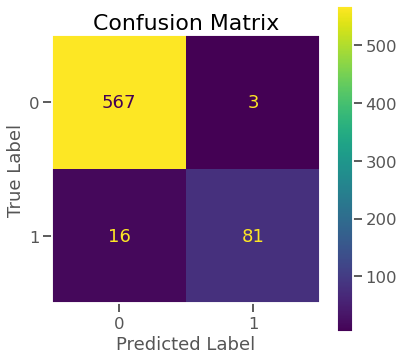

In [71]:
fig,ax = plt.subplots(figsize=(6,6))
plt.grid(False)
plot_confusion_matrix(model_grid_search_xgb.model,X_test,y_test,ax=ax);
ax.set_title('Confusion Matrix',fontsize=22);
ax.set_xlabel('Predicted Label',fontsize=18);
ax.set_ylabel('True Label',fontsize=18);

<h2>Weaknesses

By testing the final model on the test data set, I can see that the final model is pretty good but still overfitting. I think SMOTE is the main cause of this. Due to the original class imbalance, the final model was trained on a lot of generated data instead of real data. Fitting to this generated data that the test set does not also have is likely why the model performs worse on the test set than during cross validation on the training set.

<h1>Feature Importances</h1>

The most important features for predicting churn are:
<ol><li>Total Charge
<li>Customer Service Calls
<li>International Plan
<li>Total International Calls
<li>Total International Charge
</ol>

<h3>From the XGBoost Model</h3>

This model has a built in feature importances method. Not all models have this method and the ones that do are not always calculated based on the same method. Therefore, the SHAP scores below are preferred.

In [72]:
# Gets the feature importances and zips them to the feature names
feature_importance_vals = model_grid_search_xgb.model.named_steps['boost'].feature_importances_
feature_importances = dict(zip(ordinal_cols + list(numerical_cols),feature_importance_vals))

# Sorts the features by importance
feature_importances = dict(sorted(feature_importances.items(), key=lambda item: item[1]))
feature_importances

{'account length': 0.011556817,
 'total day charge': 0.014907466,
 'total eve charge': 0.018550266,
 'total intl charge': 0.04528817,
 'total intl calls': 0.083499365,
 'number vmail messages': 0.118328065,
 'customer service calls': 0.16703077,
 'total charge': 0.26784402,
 'international plan': 0.27299502}

<h3>Using SHAP (SHapley Additive exPlanations) </h3>

This shows the feature importances for the XGBoost model as well as how each feature contributed to a prediction on average.

In [73]:
# Create a SHAP Explainer
explainer = shap.Explainer(model_grid_search_xgb.model.named_steps['boost'])

# Create the features dataframe using the column transformer
X_shap_cols = column_transformer_xgb.fit_transform(X_train)
shap_columns = ordinal_cols + list(numerical_cols)
shap_columns = [name.title() for name in shap_columns]
X_shap = pd.DataFrame(X_shap_cols,columns=shap_columns)

# Calculate shap values
shap_values = explainer(X_shap)

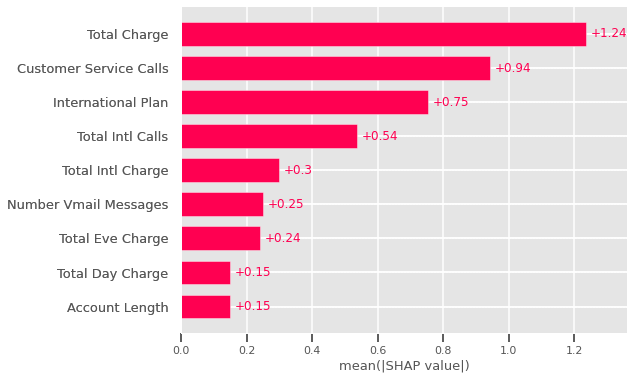

In [74]:
plt.style.use('ggplot')
shap.plots.bar(shap_values)

This plot shows the feature contributions for each feature for every prediction on the train set. Color is the value of the feature and position (left or right) is the contribution of that feature for a given point.

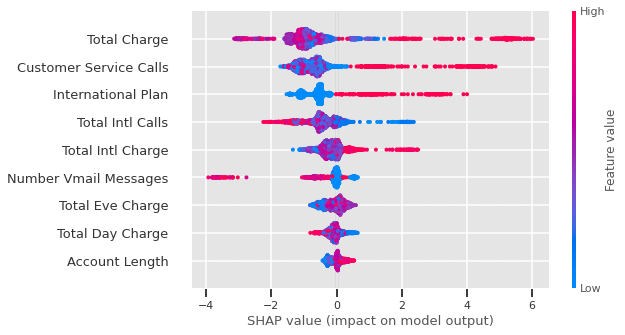

In [75]:
shap.plots.beeswarm(shap_values)

This plot shows the feature contributions for one model prediction from the train set.

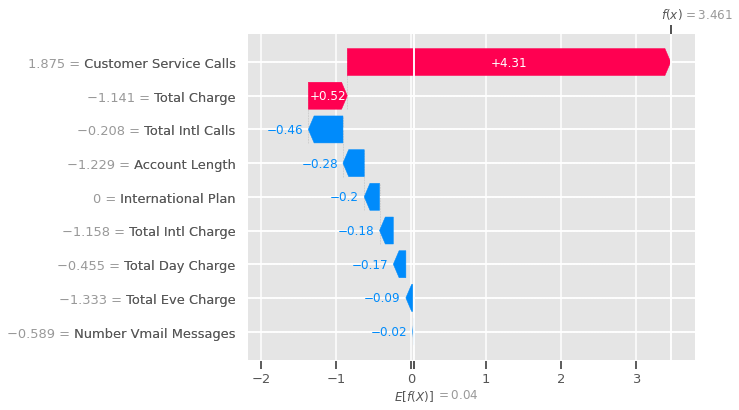

In [76]:
# Change the index to see others
shap.plots.waterfall(shap_values[42])

<h1>Conclusion

I was successful in creating a model that SyriaTel can use to predict whether a customer will churn soon. The best model was XGBoost with <b>83.5% Recall</b> and 96.4% Precision on the test set.

The most important features for predicting churn are:
<ol><li>Total Charge
<li>Customer Service Calls
<li>International Plan
<li>Total International Calls
<li>Total International Charge
</ol>

SyriaTel can use this model to offer discounts to customers who are likely to churn soon while avoiding offering unnecessary discounts to customers who are unlikely to do so.


<h1>Extra Plots & Stats for Presentation

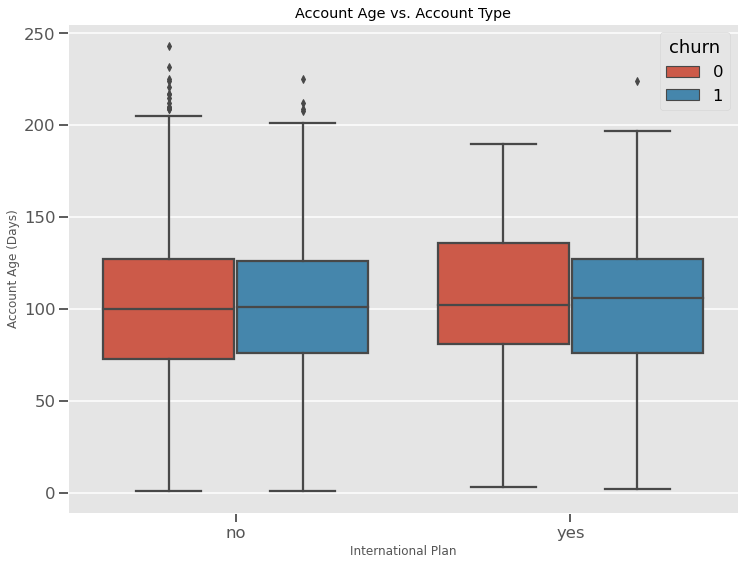

In [77]:
fig,ax = plt.subplots(figsize=(12,9))
ax.set_title('Account Age vs. Account Type')

sns.boxplot(data=s_tel,x='international plan',y='account length',hue='churn',ax=ax);
ax.set_xlabel('International Plan');
ax.set_ylabel('Account Age (Days)');

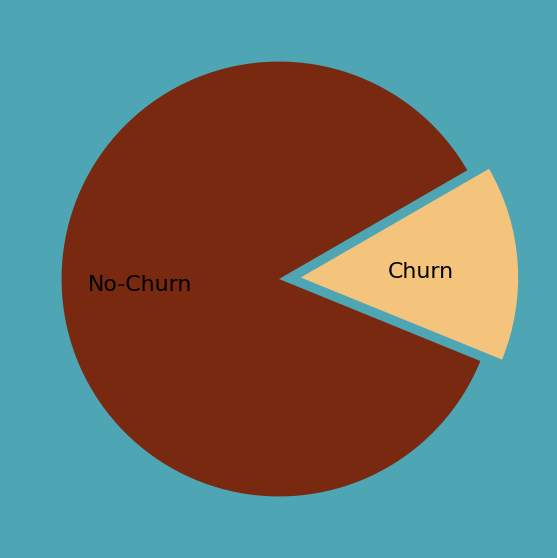

In [78]:
fig,ax = plt.subplots(figsize=(10,10))
fig.set_facecolor('#4ea6b4')
sns.set_context('poster')

# Pie chart to visualize class imbalence
ax.pie(s_tel.groupby('churn').size(),labels=['No-Churn','Churn'],labeldistance=0.4,
        startangle=30,explode=[0,0.1],colors=['#78290f','#f4c47c']);
sns.set_context('notebook')

In [79]:
bins=list(range(20,110,5))
grouped_charges = s_tel.groupby(pd.cut(s_tel['total charge'],bins=bins))['churn']
print(grouped_charges.count())
grouped_charges = grouped_charges.agg(np.mean).tolist()

total charge
(20, 25]        2
(25, 30]        7
(30, 35]       33
(35, 40]       71
(40, 45]      167
(45, 50]      321
(50, 55]      503
(55, 60]      621
(60, 65]      623
(65, 70]      459
(70, 75]      292
(75, 80]      153
(80, 85]       58
(85, 90]       18
(90, 95]        4
(95, 100]       1
(100, 105]      0
Name: churn, dtype: int64


FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


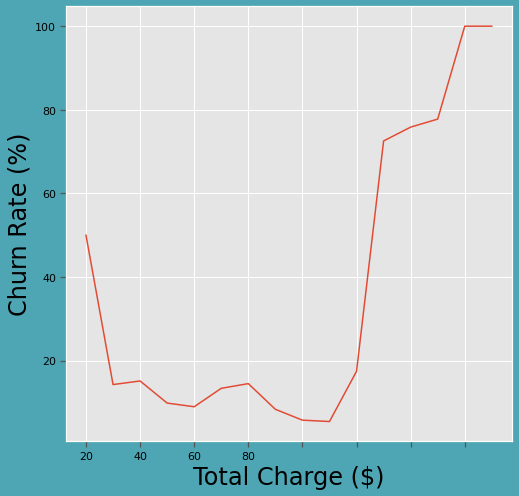

In [80]:
fig,ax = plt.subplots(figsize = (8,8))
fig.set_facecolor('#4ea6b4')
sns.lineplot(x=list(range(20,105,5)),y=grouped_charges);
ax.set_xlabel('Total Charge ($)',color='k',fontsize=24)
ax.set_ylabel('Churn Rate (%)',color='k',fontsize=24)
ax.set_xticklabels(list(range(00,100,20)),color='k');
ax.set_yticklabels([0,20,40,60,80,100],color='k');

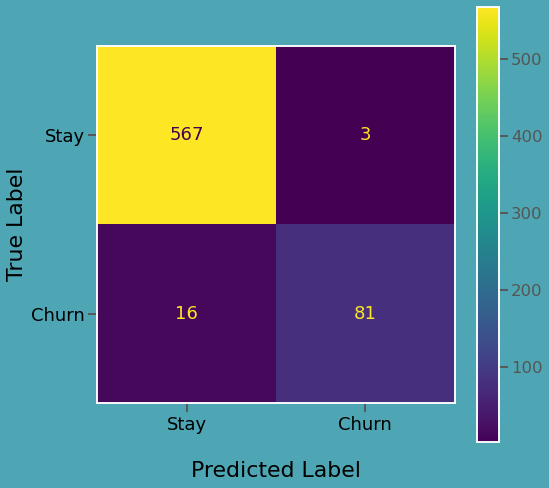

In [81]:
sns.set_context('talk')
fig,ax = plt.subplots(figsize=(8,8))
plt.grid(False)
plot_confusion_matrix(model_grid_search_xgb.model,X_test,y_test,ax=ax);
ax.set_xlabel('\nPredicted Label',fontsize=22,color='k');
ax.set_ylabel('True Label',fontsize=22,color='k');
ax.set_xticklabels(['Stay','Churn'],color='k',fontsize=18)
ax.set_yticklabels(['Stay','Churn'],color='k',fontsize=18)
fig.set_facecolor('#4ea6b4')

In [82]:
s_tel['international plan'].value_counts()

no     3010
yes     323
Name: international plan, dtype: int64

In [83]:
s_tel.groupby(['international plan','churn'])['account length'].agg(np.mean)

international plan  churn
no                  0        100.607733
                    1        101.777457
yes                 0        103.456989
                    1        104.905109
Name: account length, dtype: float64